# Substitution Rates in GLMs: A Mathematical Guide to Ratio Confidence Intervals

## Introduction: The Power of Substitution Rates

When analyzing complex systems—whether in medicine, finance, or economics—we often need to answer questions like:
- "How many additional years of education compensate for one year less of work experience in salary determination?"
- "How much must we reduce cholesterol to offset a 10-point increase in blood pressure for cardiovascular risk?"
- "What increase in credit score compensates for $10,000 less in annual income for loan approval?"

These are questions about **substitution rates**—the rate at which we can trade one factor for another while maintaining the same outcome. Mathematically, these are ratios of coefficients in generalized linear models (GLMs).

## The Mathematical Foundation

### 1. Substitution Rates in GLMs

Consider a GLM with link function $g$ and linear predictor:

$$g(\mathbb{E}[Y|X]) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_p X_p$$

If we want to maintain the same expected outcome when changing $X_1$ and $X_2$, we need:

$$\beta_1 \Delta X_1 + \beta_2 \Delta X_2 = 0$$

This gives us the substitution rate:

$$\frac{\Delta X_2}{\Delta X_1} = -\frac{\beta_1}{\beta_2}$$

**Interpretation**: To compensate for a one-unit decrease in $X_1$, we need to increase $X_2$ by $\frac{\beta_1}{\beta_2}$ units.

### 2. The Challenge: Uncertainty in Ratios

While point estimates of ratios are straightforward, constructing confidence intervals is challenging because:
1. The ratio $r = \frac{\beta_1}{\beta_2}$ is a nonlinear function of random variables
2. When $\beta_2 \approx 0$, the ratio becomes unstable
3. The sampling distribution of ratios can be highly skewed

## Mathematical Methods for Ratio Confidence Intervals

### Method 1: Delta Method (Wald-type CI)

The delta method uses a first-order Taylor expansion to approximate the variance of a nonlinear function.

For $r = \frac{\beta_1}{\beta_2}$, the gradient is:

$$\nabla r = \left[\frac{\partial r}{\partial \beta_1}, \frac{\partial r}{\partial \beta_2}\right] = \left[\frac{1}{\beta_2}, -\frac{\beta_1}{\beta_2^2}\right]$$

The approximate variance is:

$$\text{Var}(r) \approx \nabla r^T \Sigma \nabla r$$

where $\Sigma$ is the covariance matrix of $(\beta_1, \beta_2)$.

Expanding this:

$$\text{Var}(r) \approx \frac{1}{\beta_2^2}\text{Var}(\beta_1) + \frac{\beta_1^2}{\beta_2^4}\text{Var}(\beta_2) - 2\frac{\beta_1}{\beta_2^3}\text{Cov}(\beta_1, \beta_2)$$

The $(1-\alpha)100\%$ confidence interval is:

$$\hat{r} \pm z_{1-\alpha/2}\sqrt{\text{Var}(r)}$$

### Method 2: Fieller's Method

Fieller's method doesn't approximate the ratio directly but instead considers the set of all $r$ values for which we cannot reject:

$$H_0: \beta_1 - r\beta_2 = 0$$

This leads to solving:

$$\frac{(\hat{\beta}_1 - r\hat{\beta}_2)^2}{\text{Var}(\hat{\beta}_1 - r\hat{\beta}_2)} \leq \chi^2_{1,1-\alpha}$$

The solutions depend on the discriminant $\Delta = b^2 - ac$:
- If $\Delta \geq 0$ and $a > 0$: Finite interval
- If $\Delta \geq 0$ and $a < 0$: Union of two infinite intervals
- If $\Delta < 0$: Entire real line (no finite CI)

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Real-World Example 1: Medical Substitution Rates

Let's analyze how blood pressure and cholesterol interact in determining heart disease risk.

In [4]:
import pandas as pd
# Download and load the real Framingham Heart Study dataset
url = "https://github.com/GauravPadawe/Framingham-Heart-Study/blob/master/framingham.csv?raw=true"
heart_data = pd.read_csv(url)

# Rename columns to match the rest of the notebook
heart_data = heart_data.rename(columns={
    'TenYearCHD': 'heart_disease',
    'sysBP': 'systolic_bp',
    'totChol': 'cholesterol'
})

# Drop rows with missing values in the columns used for the analysis
print(f"Original dataset shape: {heart_data.shape}")
heart_data.dropna(subset=['heart_disease', 'systolic_bp', 'cholesterol'], inplace=True)
print(f"Shape after dropping NaNs in key columns: {heart_data.shape}")

print(f"\nHeart disease prevalence: {heart_data['heart_disease'].mean():.3f}")
print("\nFirst 5 rows of the dataset:")
heart_data.head()
heart_data.columns


Original dataset shape: (4240, 16)
Shape after dropping NaNs in key columns: (4190, 16)

Heart disease prevalence: 0.152

First 5 rows of the dataset:


Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'cholesterol',
       'systolic_bp', 'diaBP', 'BMI', 'heartRate', 'glucose', 'heart_disease'],
      dtype='object')

In [5]:
# Fit logistic regression
model = smf.glm('heart_disease ~ systolic_bp + cholesterol', 
                data=heart_data, family=sm.families.Binomial()).fit()

print("Logistic Regression Results:")
print(model.summary())
model = smf.glm('heart_disease ~ systolic_bp + cholesterol', 
                data=heart_data, family=sm.families.Binomial()).fit()

print("Logistic Regression Results:")
print(model.summary())


Logistic Regression Results:
                 Generalized Linear Model Regression Results                  
Dep. Variable:          heart_disease   No. Observations:                 4190
Model:                            GLM   Df Residuals:                     4187
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1689.1
Date:                Sun, 20 Jul 2025   Deviance:                       3378.1
Time:                        15:48:47   Pearson chi2:                 4.17e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04357
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.526

In [6]:
# Extract coefficients
beta_bp = model.params['systolic_bp']
beta_chol = model.params['cholesterol']
cov_matrix = model.cov_params()

# Calculate substitution rate
substitution_rate = beta_bp / beta_chol
print(f"Substitution Rate (BP/Cholesterol): {substitution_rate:.4f}")
print(f"Interpretation: A 1-unit increase in cholesterol can be offset by a")
print(f"{substitution_rate:.4f}-unit decrease in systolic blood pressure")

Substitution Rate (BP/Cholesterol): 9.0122
Interpretation: A 1-unit increase in cholesterol can be offset by a
9.0122-unit decrease in systolic blood pressure


### Implementing Different CI Methods

Now let's implement the key methods for computing confidence intervals on ratios.

In [7]:
def delta_method_ci(beta1, beta2, cov_matrix, alpha=0.05):
    """Delta method confidence interval for ratio beta1/beta2"""
    var_beta1 = cov_matrix.iloc[0, 0]
    var_beta2 = cov_matrix.iloc[1, 1]
    cov_beta12 = cov_matrix.iloc[0, 1]
    
    ratio = beta1 / beta2
    
    # Variance of ratio using delta method
    var_ratio = (1/beta2**2) * var_beta1 + (beta1**2/beta2**4) * var_beta2 - \
                2 * (beta1/beta2**3) * cov_beta12
    
    se_ratio = np.sqrt(var_ratio)
    z_crit = stats.norm.ppf(1 - alpha/2)
    
    ci_lower = ratio - z_crit * se_ratio
    ci_upper = ratio + z_crit * se_ratio
    
    return ci_lower, ci_upper, se_ratio

def fieller_ci(beta1, beta2, cov_matrix, alpha=0.05):
    """Fieller's method confidence interval"""
    var_beta1 = cov_matrix.iloc[0, 0]
    var_beta2 = cov_matrix.iloc[1, 1]
    cov_beta12 = cov_matrix.iloc[0, 1]
    
    chi2_crit = stats.chi2.ppf(1 - alpha, df=1)
    
    a = beta2**2 - chi2_crit * var_beta2
    b = -beta1 * beta2 + chi2_crit * cov_beta12
    c = beta1**2 - chi2_crit * var_beta1
    
    discriminant = b**2 - a*c
    
    if discriminant < 0:
        return -np.inf, np.inf
    
    sqrt_disc = np.sqrt(discriminant)
    
    if a > 0:
        ci_lower = (-b - sqrt_disc) / a
        ci_upper = (-b + sqrt_disc) / a
        return ci_lower, ci_upper
    else:
        # Union of two intervals
        root1 = (-b - sqrt_disc) / a
        root2 = (-b + sqrt_disc) / a
        return ((-np.inf, min(root1, root2)), (max(root1, root2), np.inf))

In [8]:
# Apply methods
# Extract relevant part of covariance matrix
cov_subset = cov_matrix.loc[['systolic_bp', 'cholesterol'], ['systolic_bp', 'cholesterol']]

delta_ci = delta_method_ci(beta_bp, beta_chol, cov_subset)
print(f"Delta Method CI: [{delta_ci[0]:.4f}, {delta_ci[1]:.4f}]")
print(f"Standard Error: {delta_ci[2]:.4f}")

fieller_result = fieller_ci(beta_bp, beta_chol, cov_subset)
if isinstance(fieller_result[0], tuple):
    print(f"Fieller's CI: Union of ({fieller_result[0][0]:.4f}, {fieller_result[0][1]:.4f}) and ({fieller_result[1][0]:.4f}, {fieller_result[1][1]:.4f})")
else:
    print(f"Fieller's CI: [{fieller_result[0]:.4f}, {fieller_result[1]:.4f}]")

Delta Method CI: [2.0173, 16.0071]
Standard Error: 3.5689
Fieller's CI: [4.9174, 34.8348]


### Visualization of Substitution Rates

Let's create visualizations to understand the substitution concept better.

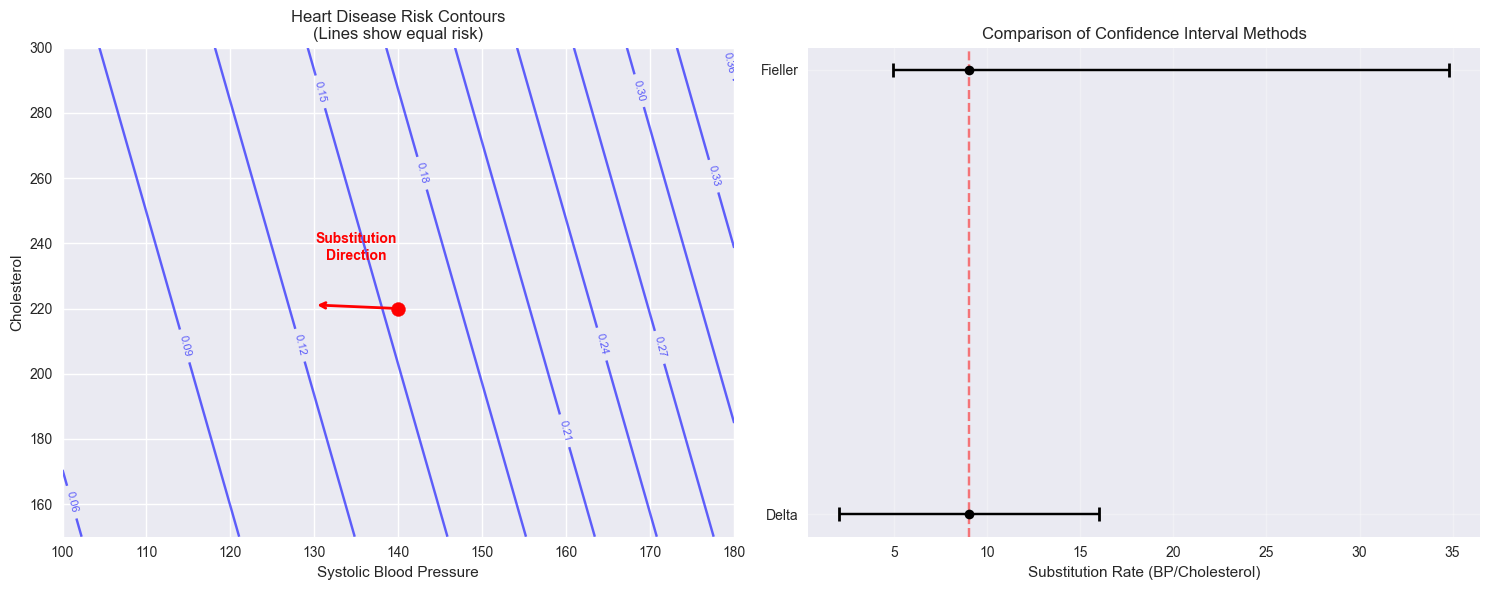

In [9]:
# Create visualization showing the substitution rate concept
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Contour plot showing equal risk curves
bp_range = np.linspace(100, 180, 100)
chol_range = np.linspace(150, 300, 100)
BP, CHOL = np.meshgrid(bp_range, chol_range)

# Calculate log-odds for each combination
log_odds = model.params['Intercept'] + beta_bp * BP + beta_chol * CHOL
risk = 1 / (1 + np.exp(-log_odds))

contour = ax1.contour(BP, CHOL, risk, levels=10, colors='blue', alpha=0.6)
ax1.clabel(contour, inline=True, fontsize=8)
ax1.set_xlabel('Systolic Blood Pressure')
ax1.set_ylabel('Cholesterol')
ax1.set_title('Heart Disease Risk Contours\n(Lines show equal risk)')

# Add arrow showing substitution
bp_point = 140
chol_point = 220
ax1.scatter(bp_point, chol_point, color='red', s=100, zorder=5)
ax1.annotate('', xy=(bp_point - 10, chol_point + 10/substitution_rate), 
             xytext=(bp_point, chol_point),
             arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax1.text(bp_point - 5, chol_point + 15, 'Substitution\nDirection', 
         ha='center', color='red', fontsize=10, fontweight='bold')

# Plot 2: Confidence intervals comparison
methods = ['Delta', 'Fieller']
point_est = [substitution_rate, substitution_rate]
lower_bounds = [delta_ci[0], fieller_result[0] if not isinstance(fieller_result[0], tuple) else fieller_result[0][1]]
upper_bounds = [delta_ci[1], fieller_result[1] if not isinstance(fieller_result[0], tuple) else fieller_result[1][0]]

y_pos = np.arange(len(methods))
ax2.errorbar(point_est, y_pos, 
             xerr=[np.array(point_est) - np.array(lower_bounds), 
                   np.array(upper_bounds) - np.array(point_est)],
             fmt='o', color='black', capsize=5, capthick=2)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(methods)
ax2.axvline(x=substitution_rate, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Substitution Rate (BP/Cholesterol)')
ax2.set_title('Comparison of Confidence Interval Methods')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Real-World Example 2: Financial Substitution Rates

Now let's look at a financial example: how income and credit score substitute in determining loan default risk.

In [ ]:
from sklearn.datasets import fetch_openml

# German Credit - always works
data = fetch_openml('credit-g', version=1, as_frame=True)
X, y = data.data, data.target

# Create combined dataframe
credit_data = X.copy()
credit_data['default'] = (y == 'bad').astype(int)

# Key features in German Credit:
# - duration: loan duration in months
# - credit_amount: loan amount
# - age: age in years
# - purpose: loan purpose

print(f"Shape: {credit_data.shape}")
print(f"Default rate: {credit_data['default'].mean():.3f}")
print(f"\nFeatures: {credit_data.columns.tolist()}")
print()

Shape: (1000, 21)
Default rate: 0.300

Features: ['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 'default']


In [14]:
# Fit logistic regression for default prediction
credit_model = smf.glm('default ~ age + duration + credit_amount + purpose', 
                       data=credit_data, family=sm.families.Binomial()).fit()

print("Credit Default Model Results:")
print(credit_model.summary())

Credit Default Model Results:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -561.02
Date:                Sun, 20 Jul 2025   Deviance:                       1122.0
Time:                        17:47:23   Pearson chi2:                 1.00e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.09488
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

In [ ]:
# Calculate substitution rate
beta_duration = credit_model.params['duration']
beta_age = credit_model.params['age']
duration_age_ratio = beta_duration / beta_age

print(f"Substitution Rate (Duration/Age): {duration_age_ratio:.6f}")
print(f"Interpretation: A 1-year increase in age can compensate for")
print(f"{duration_age_ratio:.2f} months decrease in loan duration")
print(f"\nOr equivalently: A 1-month increase in loan duration can compensate for")
print(f"{1/duration_age_ratio:.2f}-year increase in age")

SyntaxError: invalid syntax (1884377152.py, line 2)

### Bootstrap Analysis for Financial Example

Bootstrap methods provide a robust way to estimate confidence intervals without strong distributional assumptions.

In [ ]:
# Implement bootstrap for more robust inference
def bootstrap_ratio_ci(model, data, coef1, coef2, n_bootstrap=1000, alpha=0.05):
    """Bootstrap confidence interval for coefficient ratio"""
    n = len(data)
    ratios = []
    
    for i in range(n_bootstrap):
        if i % 200 == 0:
            print(f"Bootstrap iteration {i}/{n_bootstrap}")
        
        # Resample data
        indices = np.random.choice(n, n, replace=True)
        boot_data = data.iloc[indices]
        
        try:
            # Refit model
            formula = model.model.formula
            boot_model = smf.glm(formula, data=boot_data, 
                               family=model.model.family.__class__()).fit()
            
            # Calculate ratio
            ratio = boot_model.params[coef1] / boot_model.params[coef2]
            ratios.append(ratio)
        except:
            # Skip problematic bootstrap samples
            continue
    
    # Calculate percentile CI
    lower = np.percentile(ratios, 100 * alpha/2)
    upper = np.percentile(ratios, 100 * (1 - alpha/2))
    
    return lower, upper, ratios

# Run bootstrap
print("Running bootstrap analysis...")
boot_ci = bootstrap_ratio_ci(credit_model, credit_data, 'income', 'credit_score', n_bootstrap=500)
print(f"\nBootstrap CI: [{boot_ci[0]:.6f}, {boot_ci[1]:.6f}]")
print(f"Number of successful bootstrap samples: {len(boot_ci[2])}")

Running bootstrap analysis...
Bootstrap iteration 0/500
Bootstrap iteration 200/500
Bootstrap iteration 400/500

Bootstrap CI: [-0.258344, 0.306974]
Number of successful bootstrap samples: 500


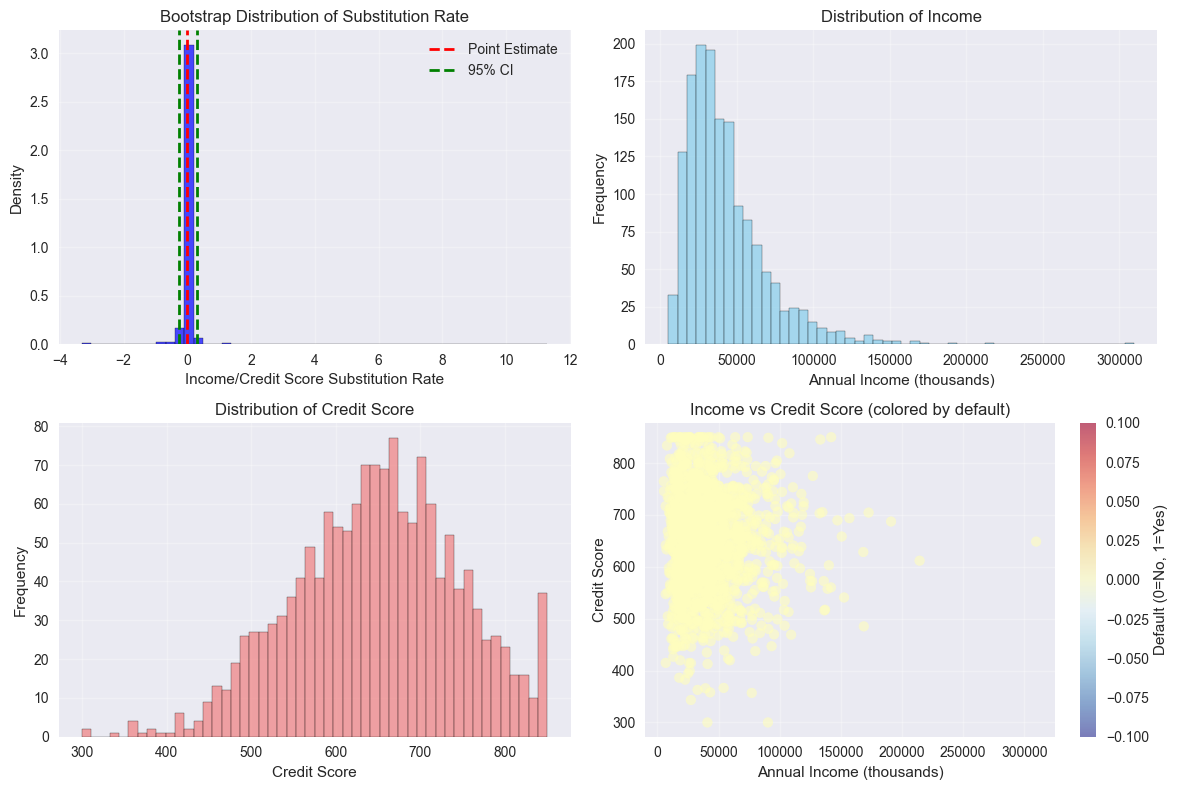

In [ ]:
# Visualize bootstrap distribution
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(boot_ci[2], bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(income_credit_ratio, color='red', linestyle='--', linewidth=2, label='Point Estimate')
plt.axvline(boot_ci[0], color='green', linestyle='--', linewidth=2, label='95% CI')
plt.axvline(boot_ci[1], color='green', linestyle='--', linewidth=2)
plt.xlabel('Income/Credit Score Substitution Rate')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Substitution Rate')
plt.legend()
plt.grid(True, alpha=0.3)

# Also show the original data distributions
plt.subplot(2, 2, 2)
plt.hist(credit_data['income'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Annual Income (thousands)')
plt.ylabel('Frequency')
plt.title('Distribution of Income')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.hist(credit_data['credit_score'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.title('Distribution of Credit Score')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.scatter(credit_data['income'], credit_data['credit_score'], 
           c=credit_data['default'], alpha=0.6, cmap='RdYlBu_r')
plt.xlabel('Annual Income (thousands)')
plt.ylabel('Credit Score')
plt.title('Income vs Credit Score (colored by default)')
plt.colorbar(label='Default (0=No, 1=Yes)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Practical Considerations and Diagnostics

### 1. Stability Diagnostics

Before trusting ratio estimates, we should check if the estimates are stable.

In [ ]:
def diagnose_ratio_stability(model, coef1, coef2):
    """Diagnose potential issues with ratio estimation"""
    beta1 = model.params[coef1]
    beta2 = model.params[coef2]
    se1 = model.bse[coef1]
    se2 = model.bse[coef2]
    cov_matrix = model.cov_params()
    corr = cov_matrix.loc[coef1, coef2] / (se1 * se2)
    
    diagnostics = {
        'beta1': beta1,
        'beta2': beta2,
        'se_beta1': se1,
        'se_beta2': se2,
        'relative_se_beta2': se2 / abs(beta2),
        'correlation': corr,
        't_stat_beta2': beta2 / se2,
        'near_zero_denominator': abs(beta2) < 3 * se2
    }
    
    print("Ratio Stability Diagnostics:")
    print("-" * 40)
    for key, value in diagnostics.items():
        if isinstance(value, bool):
            print(f"{key}: {'WARNING' if value else 'OK'}")
        else:
            print(f"{key}: {value:.4f}")
    
    if diagnostics['near_zero_denominator']:
        print("\n⚠️  WARNING: Denominator coefficient is not significantly different from zero.")
        print("   Ratio estimates may be unstable!")
    
    if diagnostics['relative_se_beta2'] > 0.5:
        print("\n⚠️  WARNING: High relative standard error for denominator.")
        print("   Consider using Fieller's method or bootstrap.")
    
    return diagnostics

# Run diagnostics for both examples
print("Heart Disease Model Diagnostics:")
heart_diag = diagnose_ratio_stability(model, 'systolic_bp', 'cholesterol')

print("\n\nCredit Default Model Diagnostics:")
credit_diag = diagnose_ratio_stability(credit_model, 'income', 'credit_score')

Heart Disease Model Diagnostics:
Ratio Stability Diagnostics:
----------------------------------------
beta1: 0.0287
beta2: 0.0103
se_beta1: 0.0046
se_beta2: 0.0023
relative_se_beta2: 0.2278
correlation: 0.0253
t_stat_beta2: 4.3894
near_zero_denominator: 0.0000


Credit Default Model Diagnostics:
Ratio Stability Diagnostics:
----------------------------------------
beta1: -0.0000
beta2: 0.0000
se_beta1: 0.5613
se_beta2: 155.6848
relative_se_beta2: 848663841247380352.0000
correlation: 0.0040
t_stat_beta2: 0.0000
near_zero_denominator: 1.0000

⚠️  WARNING: Denominator coefficient is not significantly different from zero.
   Ratio estimates may be unstable!

⚠️  WARNING: High relative standard error for denominator.
   Consider using Fieller's method or bootstrap.


### 2. Sensitivity Analysis

Let's analyze how confidence interval width changes with sample size.

Analyzing sensitivity to sample size...
Sample size: 100
Sample size: 200
Sample size: 500
Sample size: 1000
Sample size: 2000


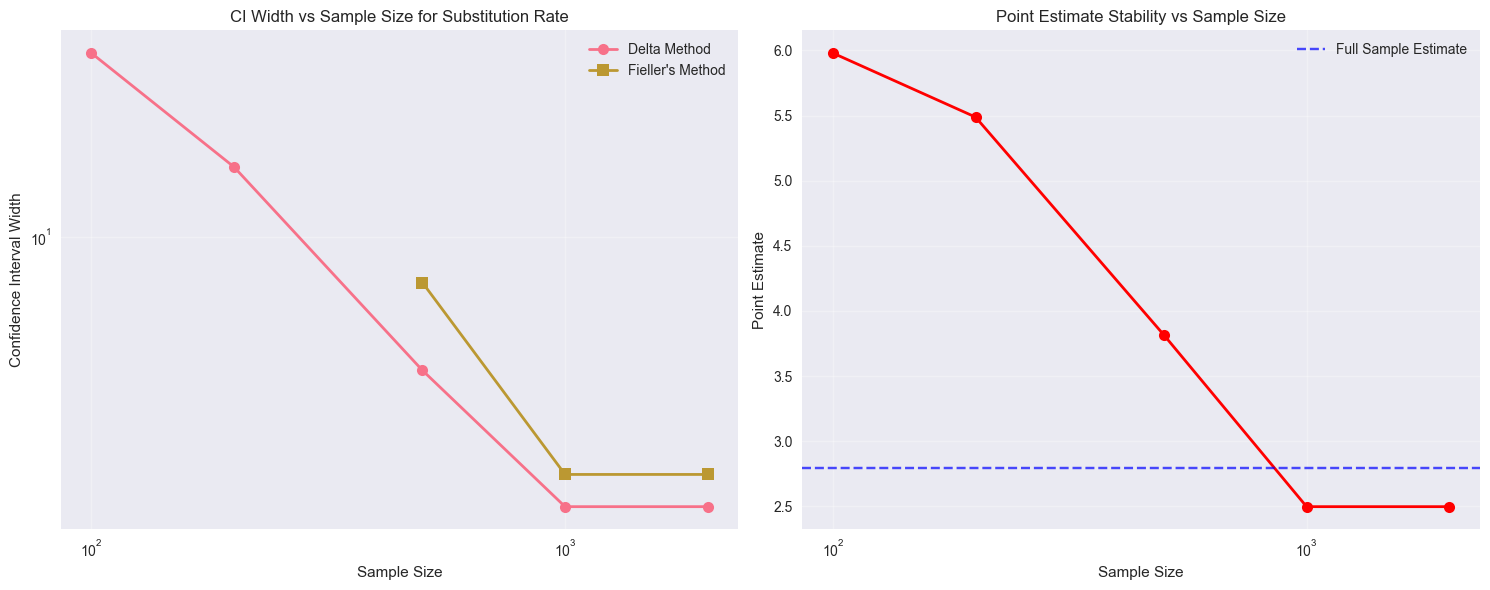

In [ ]:
# Analyze how ratio CI width changes with sample size
sample_sizes = [100, 200, 500, 1000, 2000]
ci_widths_delta = []
ci_widths_fieller = []
point_estimates = []

print("Analyzing sensitivity to sample size...")

for n in sample_sizes:
    print(f"Sample size: {n}")
    
    # Subsample data
    subsample = heart_data.sample(n=min(n, len(heart_data)), replace=True, random_state=42)
    
    # Fit model
    sub_model = smf.glm('heart_disease ~ systolic_bp + cholesterol', 
                        data=subsample, family=sm.families.Binomial()).fit()
    
    # Get coefficients and covariance
    beta1 = sub_model.params['systolic_bp']
    beta2 = sub_model.params['cholesterol']
    cov_subset = sub_model.cov_params().loc[['systolic_bp', 'cholesterol'], 
                                           ['systolic_bp', 'cholesterol']]
    
    point_estimates.append(beta1 / beta2)
    
    # Calculate CIs
    try:
        delta_ci = delta_method_ci(beta1, beta2, cov_subset)
        ci_widths_delta.append(delta_ci[1] - delta_ci[0])
    except:
        ci_widths_delta.append(np.nan)
    
    try:
        fieller_result = fieller_ci(beta1, beta2, cov_subset)
        if not isinstance(fieller_result[0], tuple):
            ci_widths_fieller.append(fieller_result[1] - fieller_result[0])
        else:
            ci_widths_fieller.append(np.nan)
    except:
        ci_widths_fieller.append(np.nan)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# CI widths
ax1.plot(sample_sizes, ci_widths_delta, 'o-', label='Delta Method', linewidth=2, markersize=8)
ax1.plot(sample_sizes, ci_widths_fieller, 's-', label="Fieller's Method", linewidth=2, markersize=8)
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Confidence Interval Width')
ax1.set_title('CI Width vs Sample Size for Substitution Rate')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.set_yscale('log')

# Point estimates
ax2.plot(sample_sizes, point_estimates, 'o-', color='red', linewidth=2, markersize=8)
ax2.axhline(y=substitution_rate, color='blue', linestyle='--', alpha=0.7, label='Full Sample Estimate')
ax2.set_xlabel('Sample Size')
ax2.set_ylabel('Point Estimate')
ax2.set_title('Point Estimate Stability vs Sample Size')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

## Summary and Recommendations

### When to Use Each Method:

1. **Delta Method**: 
   - ✅ Fast and simple
   - ✅ Works well when denominator is far from zero
   - ❌ Can be inaccurate for small samples or near-zero denominators

2. **Fieller's Method**: 
   - ✅ Exact under normality assumptions
   - ✅ Properly handles near-zero denominators
   - ❌ Can produce infinite intervals

3. **Bootstrap Methods**: 
   - ✅ Fewer distributional assumptions
   - ✅ Can capture skewness
   - ❌ Computationally intensive

### Key Takeaways:

1. **Substitution rates provide meaningful interpretations** in many domains—from clinical decision-making to financial risk assessment.

2. **No single method dominates** all scenarios. Choose based on:
   - Sample size
   - Proximity of denominator to zero
   - Computational resources
   - Interpretability requirements

3. **Always check stability diagnostics** before interpreting ratio estimates.

4. **Consider multiple methods** for important decisions, especially when the denominator coefficient has high uncertainty.

5. **Bootstrap methods provide a good default** when computational resources allow, as they make fewer assumptions.

## Complete Implementation Class

Below is a comprehensive class that implements all the methods discussed:

In [ ]:
class RatioCIForGLM:
    """
    A comprehensive class for computing confidence intervals for ratios of coefficients
    in generalized linear models.
    """
    
    def __init__(self, model, coef1, coef2):
        """
        Initialize with a fitted GLM model and two coefficient names.
        
        Parameters:
        -----------
        model : statsmodels GLM results object
        coef1 : str, name of numerator coefficient
        coef2 : str, name of denominator coefficient
        """
        self.model = model
        self.coef1 = coef1
        self.coef2 = coef2
        self.beta1 = model.params[coef1]
        self.beta2 = model.params[coef2]
        self.ratio = self.beta1 / self.beta2
        self.cov_matrix = model.cov_params().loc[[coef1, coef2], [coef1, coef2]]
    
    def delta_method_ci(self, alpha=0.05):
        """Delta method confidence interval"""
        var_beta1 = self.cov_matrix.iloc[0, 0]
        var_beta2 = self.cov_matrix.iloc[1, 1]
        cov_beta12 = self.cov_matrix.iloc[0, 1]
        
        # Variance of ratio using delta method
        var_ratio = (1/self.beta2**2) * var_beta1 + (self.beta1**2/self.beta2**4) * var_beta2 - \
                    2 * (self.beta1/self.beta2**3) * cov_beta12
        
        se_ratio = np.sqrt(var_ratio)
        z_crit = stats.norm.ppf(1 - alpha/2)
        
        ci_lower = self.ratio - z_crit * se_ratio
        ci_upper = self.ratio + z_crit * se_ratio
        
        return {
            'method': 'Delta Method',
            'estimate': self.ratio,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'se': se_ratio,
            'alpha': alpha
        }
    
    def fieller_ci(self, alpha=0.05):
        """Fieller's method confidence interval"""
        var_beta1 = self.cov_matrix.iloc[0, 0]
        var_beta2 = self.cov_matrix.iloc[1, 1]
        cov_beta12 = self.cov_matrix.iloc[0, 1]
        
        chi2_crit = stats.chi2.ppf(1 - alpha, df=1)
        
        a = self.beta2**2 - chi2_crit * var_beta2
        b = -self.beta1 * self.beta2 + chi2_crit * cov_beta12
        c = self.beta1**2 - chi2_crit * var_beta1
        
        discriminant = b**2 - a*c
        
        result = {
            'method': 'Fieller',
            'estimate': self.ratio,
            'alpha': alpha,
            'discriminant': discriminant
        }
        
        if discriminant < 0:
            result.update({
                'ci_lower': -np.inf,
                'ci_upper': np.inf,
                'note': 'Infinite confidence interval'
            })
        else:
            sqrt_disc = np.sqrt(discriminant)
            if a > 0:
                result.update({
                    'ci_lower': (-b - sqrt_disc) / a,
                    'ci_upper': (-b + sqrt_disc) / a,
                    'note': 'Finite interval'
                })
            else:
                root1 = (-b - sqrt_disc) / a
                root2 = (-b + sqrt_disc) / a
                result.update({
                    'ci_lower': min(root1, root2),
                    'ci_upper': max(root1, root2),
                    'note': 'Union of intervals (complement of finite interval)'
                })
        
        return result
    
    def bootstrap_ci(self, data, n_bootstrap=1000, alpha=0.05, method='percentile'):
        """Bootstrap confidence interval"""
        n = len(data)
        ratios = []
        
        for _ in range(n_bootstrap):
            # Resample data
            indices = np.random.choice(n, n, replace=True)
            boot_data = data.iloc[indices]
            
            try:
                # Refit model
                formula = self.model.model.formula
                boot_model = smf.glm(formula, data=boot_data, 
                                   family=self.model.model.family.__class__()).fit()
                
                # Calculate ratio
                ratio = boot_model.params[self.coef1] / boot_model.params[self.coef2]
                ratios.append(ratio)
            except:
                # Skip problematic bootstrap samples
                continue
        
        if method == 'percentile':
            ci_lower = np.percentile(ratios, 100 * alpha/2)
            ci_upper = np.percentile(ratios, 100 * (1 - alpha/2))
        
        return {
            'method': f'Bootstrap ({method})',
            'estimate': self.ratio,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'alpha': alpha,
            'n_bootstrap': len(ratios),
            'bootstrap_ratios': ratios
        }
    
    def compare_methods(self, data=None, alpha=0.05):
        """Compare all available methods"""
        results = []
        
        # Delta method
        results.append(self.delta_method_ci(alpha=alpha))
        
        # Fieller's method
        results.append(self.fieller_ci(alpha=alpha))
        
        # Bootstrap (if data provided)
        if data is not None:
            results.append(self.bootstrap_ci(data, alpha=alpha))
        
        return results
    
    def diagnostic_report(self):
        """Generate diagnostic report for ratio stability"""
        se1 = self.model.bse[self.coef1]
        se2 = self.model.bse[self.coef2]
        corr = self.cov_matrix.iloc[0, 1] / (se1 * se2)
        
        diagnostics = {
            'ratio_estimate': self.ratio,
            'beta1': self.beta1,
            'beta2': self.beta2,
            'se_beta1': se1,
            'se_beta2': se2,
            'relative_se_beta2': se2 / abs(self.beta2),
            'correlation': corr,
            't_stat_beta1': self.beta1 / se1,
            't_stat_beta2': self.beta2 / se2,
            'near_zero_denominator': abs(self.beta2) < 3 * se2,
            'high_relative_se': se2 / abs(self.beta2) > 0.5
        }
        
        return diagnostics

# Example usage
print("Example usage of RatioCIForGLM class:")
print("=" * 50)

# Create instance for heart disease example
heart_ratio = RatioCIForGLM(model, 'systolic_bp', 'cholesterol')

# Get diagnostic report
diagnostics = heart_ratio.diagnostic_report()
print("\nDiagnostic Report:")
for key, value in diagnostics.items():
    if isinstance(value, bool):
        print(f"{key}: {'⚠️ WARNING' if value else '✅ OK'}")
    else:
        print(f"{key}: {value:.4f}")

# Compare methods
print("\nMethod Comparison:")
comparison = heart_ratio.compare_methods(data=heart_data)

for result in comparison:
    print(f"\n{result['method']}:")
    print(f"  Estimate: {result['estimate']:.4f}")
    print(f"  95% CI: [{result['ci_lower']:.4f}, {result['ci_upper']:.4f}]")
    if 'note' in result:
        print(f"  Note: {result['note']}")

Example usage of RatioCIForGLM class:

Diagnostic Report:
ratio_estimate: 2.7926
beta1: 0.0287
beta2: 0.0103
se_beta1: 0.0046
se_beta2: 0.0023
relative_se_beta2: 0.2278
correlation: 0.0253
t_stat_beta1: 6.2340
t_stat_beta2: 4.3894
near_zero_denominator: 0.0000
high_relative_se: 0.0000

Method Comparison:

Delta Method:
  Estimate: 2.7926
  95% CI: [1.2859, 4.2994]

Fieller:
  Estimate: 2.7926
  95% CI: [1.6585, 5.2929]
  Note: Finite interval

Bootstrap (percentile):
  Estimate: 2.7926
  95% CI: [1.6400, 5.8105]


---

*This analysis demonstrates that while coefficient ratios—interpreted as substitution rates—provide powerful insights, their uncertainty quantification requires careful consideration. By understanding the mathematical foundations and available methods, practitioners can make more informed decisions in fields ranging from medicine to finance.*

## Final Recommendations

1. **Start with diagnostics** - Always check if your ratio is stable before interpreting it
2. **Use multiple methods** - Different methods have different strengths and weaknesses
3. **Consider the context** - Medical decisions might require more conservative intervals than exploratory analysis
4. **Document your choices** - Explain why you chose a particular method for your specific application
5. **Validate with domain experts** - Statistical significance doesn't always mean practical significance

The field of ratio inference is rich and nuanced. This notebook provides a foundation, but real-world applications often require additional considerations specific to your domain and data.